In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 1. 기울기 계산 법

### 임의의 수식

In [2]:
def f(x):
    return 3* x**2 - 4*x +5

In [3]:
f(3.0)

20.0

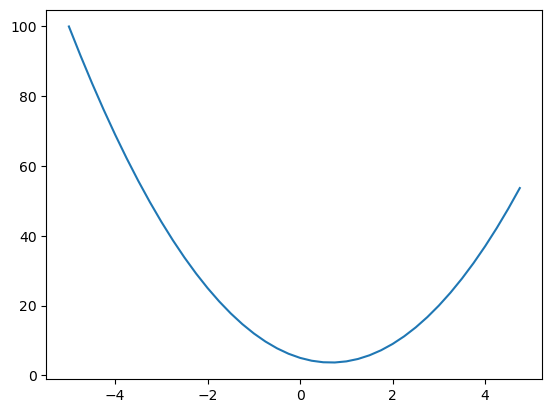

In [4]:
x_list = np.arange(-5,5,0.25)
y_list = f(x_list)
plt.plot(x_list, y_list);

---

미분을 한다면....

위 수식 grad = 6x -4

grad(4) = 6*4 - 4 = 20


---

직접 기울기를 계산해보자

h가 매우 작으면 그 지점의 기울기를 뜻한다...(적당한 h로 기울기를 계산)

In [5]:
h = 0.0000001
x = 4

slope = (f(x+h) - f(x))/h
slope

20.000000375830496

### 신경망 수식으로 다시 해보자

In [6]:
x = 2.0
w = -3.0
b = 10.0

y = w*x + b
print(y)

4.0


In [7]:
# 
h = 0.001

x = 2.0
w = -3.0
b = 10.0

print(f"y = wx + b ==> {(w)}x +{b}, (x = 2)")
print('-'*40)


y_pred_1 = w*x + b
x += h
y_pred_2 = w*x + b
x -= h

print('y_pred_1 =', y_pred_1)
print('y_pred_2 =', y_pred_2)
print('slope(== w) =', (y_pred_2-y_pred_1)/h)
print('-'*40)


y_pred_1 = w*x + b
w += h
y_pred_2 = w*x + b
w -= h

print('y_pred_1 =', y_pred_1)
print('y_pred_2 =', y_pred_2)
print('slope(== x) =', (y_pred_2-y_pred_1)/h)
print('-'*40)


y_pred_1 = w*x + b
b += h
y_pred_2 = w*x + b
b -= h

print('y_pred_1 =', y_pred_1)
print('y_pred_2 =', y_pred_2)
print('slope(== 상수항) =', (y_pred_2-y_pred_1)/h)
print('-'*40)

y = wx + b ==> -3.0x +10.0, (x = 2)
----------------------------------------
y_pred_1 = 4.0
y_pred_2 = 3.997
slope(== w) = -3.0000000000001137
----------------------------------------
y_pred_1 = 4.0
y_pred_2 = 4.002
slope(== x) = 1.9999999999997797
----------------------------------------
y_pred_1 = 4.0
y_pred_2 = 4.0009999999999994
slope(== 상수항) = 0.9999999999994458
----------------------------------------


# 2. 신경망 공부를 위한 클래스 구현

lambda는 쓰고 버리는 일시적인 함수이다. (lambda는 런타임에 생성해서 사용할 수 있는 '익명 함수' 이다)

즉, 간단한 기능을 일반적인 함수와 같이 정의해두고 쓰는 것이 아니고 

필요한 곳에서 즉시 사용하고 버릴 수 있기 때문에 코드가 간결해지고 메모리가 절약된다.

클래스 생성자로 아무것도 안하는 빈 lambda함수를 선언하고 밑에서 함수를 정의한다. 

> 굳이 왜? 

> 여기서 backward는 add, mul 에 따라 달라지기 때문에 이렇게 구현하는게 좋을 수도...!

**_backward 뒤에 ()를 붙이면 안되는 이유....**

_backward는 함수로 선언한게 맞고 
우리는 그 함수를 변수로서 받아서 사용하기 때문에 

어떠한 함수에서 _backward() 함수를 변수로 활용하는 것이기 때문에 ()를 붙이지 않는다.

붙이면 다음과 같은 에러가 발생한다.

`TypeError: 'NoneType' object is not callable`


앞에 언더바 한 개의 의미 : 내부 사용용

앞 뒤 언더바 2개의 의미 : 매직 메소드 (참고 : https://seongonion.tistory.com/128)

In [111]:
import numpy as np

class Value:
    def __init__(self, data, _children=(), _op='', label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda:None # 맨 처음 아무 것도 수행하지 않는 단순한 함수로 정의하고싶음. 그래서 빈 람다가 필요, 나중에 함수를 정의하고 사용!
        self._prev = set(_children) # 계산에 사용된 숫자를 나타냄.
        self._op = _op              # 계산에 사용된 기호를 나타냄
        self.label = label          # data의 label

    
    def __repr__(self):
        return f"Value(data={self.data})"

    
    def __add__(self, other): # self + other
        other = other if isinstance(other, Value) else Value(other) # isinstance(확인하고자 하는 데이터 값, 확인하고자 하는 데이터 타입) # 참고: https://blockdmask.tistory.com/536
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # 이전 노드의(즉, 계산 후 노드) gard * 1
            self.grad += out.grad * 1
            other.grad += out.grad * 1
        out._backward = _backward
        return out

    
    def __mul__(self, other): # self * other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # 이전 노드의(즉, 계산 후 노드) gard * 계산에 쓰인 상대값
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out

    def __rmul__(self, other): # 정수 * value 일때, mul이 안되면 rmul을 자동실행 후 다시 mul 실행?
        return self * other

    def __truediv__(self, other): # self / other (나누기를 이렇게 표현 )
        return self * other**-1
    

    def __neg__(self):  # -self
        return self * -1

    def __sub__(self, other):  # self - other
        return self + (-other)
    
    
    def __pow__(self, other):
        # assert는 뒤의 조건이 True가 아니면 AssertError를 발생한다. 참고 : https://wikidocs.net/21050
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        # 제곱의 미분 : other * self.data**(other-1)
        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward
        return out
    
    

    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t,(self,), 'tanh')

        def _backward():
            # tanh의 미분 값 * 이전 노드의(즉, 계산 후 노드) gard
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out


    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            # e^x 미분 값 * 이전 노드의(즉, 계산 후 노드) gard (e^4x 미분은 4e^4x)
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    

    def backward(self):
        # 위상 정렬로 data 순서대로 담기
        topological = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topological.append(v)
        build_topo(self)

        # 맨 마지막 grad 1 설정
        self.grad = 1.0

        # 정렬 순서대로 backward 계산 진행
        for node in reversed(topological):
            node._backward()
            

    def np_tanh(self):
        n = self.data
        t = np.tanh(n)
        out =  Value(t,(self,), 'np_tanh')
        return out


In [114]:
a = Value(2.0)
b = Value(4.0)

a / b

Value(data=0.5)

### 순전파 그래프로 표현하기

In [21]:
#!pip install graphviz (안됨;)
#!conda install python-graphviz

In [22]:
from graphviz import Digraph

def trace(root):
    # 순전파 노드, 엣지 표현
    nodes, edges = set(), set()

    def build(value):
        if value not in nodes:  # 지금 value가 노드에 없으면 
            nodes.add(value)    # nodes에 넣어라
            for child in value._prev:        # value계산에 사용된 다른 숫자들
                edges.add((child, value))    # edges에 (지금 value의 child, 지금 value) 튜플을 넣어라
                build(child)                 # build 함수 반복 
                
    build(root)
    return nodes, edges

def draw_dot(root):      #root_node == 마지막 계산값을 의미? 마지막 노드?
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'}) # LR = left to rignt, L -> R

    nodes, edges = trace(root)   # 모든 계산 value 추적해서 nodes, edges로 반환

    for n in nodes:
        uid = str(id(n)) # id 함수는 인자로 객체를 입력 받고, 입력 받은 그 객체의 고유 주소 값을 반환하는 함수 

        # 값마다 사각형 노드로 표현
        dot.node(name = uid, label = "{ %s | data %.3f | grad %.3f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # 만약 어떤 기호로 계산 됬다면 사각형 노드를 하나 만들어라
            dot.node(name = uid + n._op, label = n._op)
            # 그리고 선을 이어라
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # n1, n2 == (지금 value의 child, 지금 value)
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot


# 3. 수동 역전파 예시 1 (간단한 수식)

In [11]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

e = a*b; e.label = 'e'
d = e + c; d.label = 'd'

f = Value(-2.0, label='f')
L = d*f; L.label="L"
print(L)
print(L._prev)
print(L._op)

Value(data=-8.0)
{Value(data=-2.0), Value(data=4.0)}
*


In [12]:
trace(L)

({Value(data=-2.0),
  Value(data=-3.0),
  Value(data=-6.0),
  Value(data=-8.0),
  Value(data=10.0),
  Value(data=2.0),
  Value(data=4.0)},
 {(Value(data=-2.0), Value(data=-8.0)),
  (Value(data=-3.0), Value(data=-6.0)),
  (Value(data=-6.0), Value(data=4.0)),
  (Value(data=10.0), Value(data=4.0)),
  (Value(data=2.0), Value(data=-6.0)),
  (Value(data=4.0), Value(data=-8.0))})

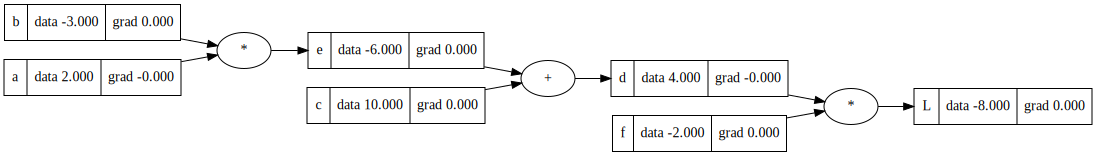

In [13]:
draw_dot(L)

## grad를 함수로 구해보자

In [14]:
def check_grad():
    # Layer계산을 반복한다 했을때 다음 h를 넣은 위치에서의 grad를 구할 수 있다.
    # layer계산 => h넣고 layer 계산, h를 넣은 위치에서의 grad 

    # ex) 맨 마지막 node에서는 grad가 1이 나올 수 밖에 없다. (아무 계산이 없으니 그냥 상수항 미분값?)
    
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label="L"
    L1 = L.data

    a = Value(2.0 , label='a')
    b = Value(-3.0+ h, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label="L"
    L2 = L.data 

    print((L2 - L1)/h)

check_grad()

-3.9999999999995595


즉, L.grad = 1

## grad 직접 계산해서 구해보자

## 1. L -> f , d

L = d * f

#### dL/dd = ??

=> [기본식] (f(x+h) - f(x)) / h 

    > f(x+h) = (d+h)*f <br>
    > f(x) = (d*f) <br>
    
=> ((d+h)*f) - (d*f) / h <br>
=> (d*f) + (h*f) - (d*f) / h <br>
=> (h*f) / h <br>
=> f


#### dL/df = ??

=> [기본식] (f(x+h) - f(x)) / h 

    > f(x+h) = (f+h)*d <br>
    > f(x) = (d*f) <br>
    
=> ((f+h)*d - (d*f) / h <br>
=> (d*f) + (d*h) - (d*f) / h <br>
=> (d*h) / h <br>
=> d


즉,<br>
f.grad = 4.00 <br>
d.grad = -2.00

## 2. L -> c, e

dL/dc, dL/de를 구하기 위해서는 체인룰 (chain rule) 기법을 사용해야 한다.

### 1) dL/dc = dL/dd * dd/dc

### 2) dL/de = dL/dd * dd/de

먼저 dd/dc , dd/de를 구해보자

d = c + e

#### dd/dc = ??

=> [기본식] (f(x+h) - f(x)) / h 

    > f(x+h) = (c+h)+e <br>
    > f(x) = (c+e) <br>
    
=> ((c+h)+e - (c+e) / h <br>
=> h / h <br>
=> 1

#### dd/de = ??

=> [기본식] (f(x+h) - f(x)) / h 

    > f(x+h) = (e+h)+c <br>
    > f(x) = (c+e) <br>
    
=> ((e+h)+c - (c+e) / h <br>
=> h / h <br>
=> 1

단순 더하기는 grad가 1이다!..

위 결과들을 토대로 

1) dL/dc = dL/dd * dd/dc

    > dL/dd = f <br>
    > dd/dc = 1 <br>

=> f * 1<br>
=> f


2) dL/de = dL/dd * dd/de

    > dL/dd = f <br>
    > dd/de = 1 <br>

=> f * 1<br>
=> f

즉,<br>
c.grad = -2.00 <br>
e.grad = -2.00

## 3. L -> a, b

dL/da, dL/db를 구하기 위해서는 체인룰 (chain rule) 기법을 사용해야 한다.

### 1) dL/da = dL/de * de/da

### 2) dL/db = dL/de * de/db

먼저 de/da , de/db를 구해보자

e = a*b

#### de/da = ??

=> [기본식] (f(x+h) - f(x)) / h 

    > f(x+h) = (a+h)*b <br>
    > f(x) = a*b <br>
    
=> ((a+h)*b - a*b) / h <br>
=> hb / h <br>
=> b

#### de/db = ??

=> [기본식] (f(x+h) - f(x)) / h 

    > f(x+h) = (b+h)*a <br>
    > f(x) = a*b <br>
    
=> ((b+h)*a - a*b) / h <br>
=> ha / h <br>
=> a

위 결과들을 토대로 

1) dL/da = dL/de * de/da

    > dL/de = f <br>
    > de/da = b <br>

=> f * b<br>
=> -2 * -3 = 6


2) dL/db = dL/de * de/db

    > dL/de = f <br>
    > de/db = a <br>

=> f * a<br>
=> -2 * 2 = -4

즉,<br>
a.grad = 6.0 <br>
b.grad = -4.0

### backprapagation gard 계산 정리

- 곱하기 backpropagation (반대방향이라는 조건)

    => (이전 노드의 gard) * (상대노드의 data)
  
    **=> (이전 노드의 gard) * 곱하기 연산의 미분 값**
  

- 더하기 backpropagation (반대방향이라는 조건)

    => (이전 노드의 gard) * 1
  
    **=> (이전 노드의 gard) * 더하기 연산의 미분 값**


In [15]:
L.grad = 1.0

# 곱하기 backpropagation (반대방향이라는 조건)
# (이전 노드의 gard) * 곱하기 연산의 미분 값

f.grad = 4.0    # d.data * L.grad
d.grad = -2.0   # f.data * L.grad

# 더하기 backpropagation (반대방향이라는 조건)
# (이전 노드의 gard) * 더하기 연산의 미분 값

c.grad = -2.0   # d.gard * 1
e.grad = -2.0   # d.gard * 1

a.grad = 6.0    # b.data * e.grad
b.grad = -4.0   # a.data * e.grad

# 정리해 보면

어떤 노드의 grad = 

지금 노드의 연산식을 미분한 값 * 계산 후 의 grad 값

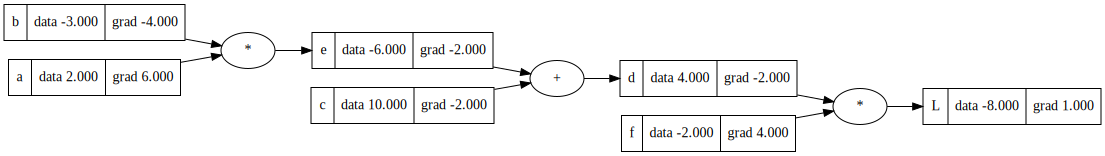

In [16]:
draw_dot(L)

## 가중치 업데이트 

In [17]:
learning_rate = 0.001

a.data += learning_rate * a.grad
b.data += learning_rate * b.grad
c.data += learning_rate * c.grad
f.data += learning_rate * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.928064095999999


# 4. 수동 역전파 예시 2 (뉴런)

## 활성화 함수?

인간의 뉴런처럼 다른 여러개의 뉴런으로부터 입력값을 받아서 
세포체(cell body)에 저장하다가 자신의 용량을 넘어서면 외부로 출력값을 내보내는 것처럼, 

인공신경망의 뉴런도 여러 입력값을 받아서 일정 수준을 넘어서면 활성화되어 출력값을 내보낸다.

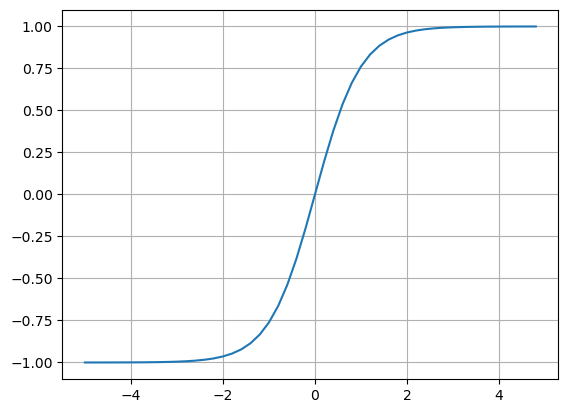

In [18]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)));
plt.grid();

In [68]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weight x1, x2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813, label='b')

w1x1 = w1 * x1; w1x1.label = "w1 * x1"
w2x2 = w2 * x2; w2x2.label = "w2 * x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1*x1 + w2*x2"

n = w1x1w2x2 + b; n.label = "n"

# 위 value클래스에 tanh() 함수를 구현!
o = n.tanh(); o.label = 'o'

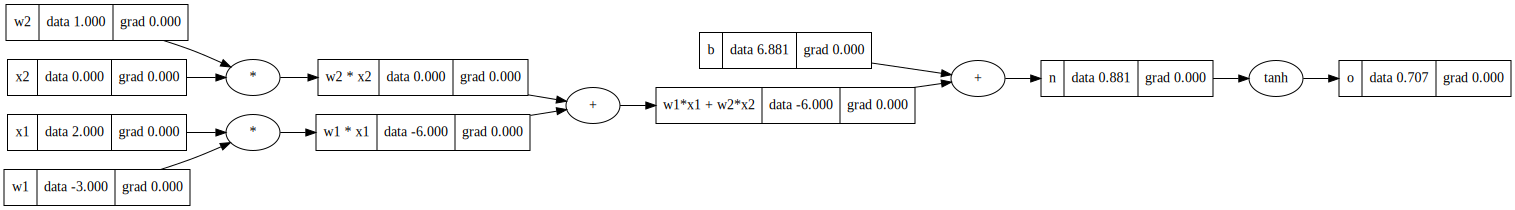

In [69]:
draw_dot(o)

In [70]:
# 위 과정 backpropagation grad 연산


# 맨 마지막 grad = 1
o.grad = 1.0


# tanh의 미분
# 1 - tanh(x)**2
# do/dn = 1 - o**2
n.grad = (1 - o.data**2)


# 더하기 연산
w1x1w2x2.grad = n.grad * 1
b.grad = n.grad * 1


# 또 더하기 
w1x1.grad = w1x1w2x2.grad * 1
w2x2.grad = w1x1w2x2.grad * 1


# 곱하기 
w1.grad = x1.data * w1x1.grad
x1.grad = w1.data * w1x1.grad

w2.grad = x2.data * w2x2.grad
x2.grad = w2.data * w2x2.grad

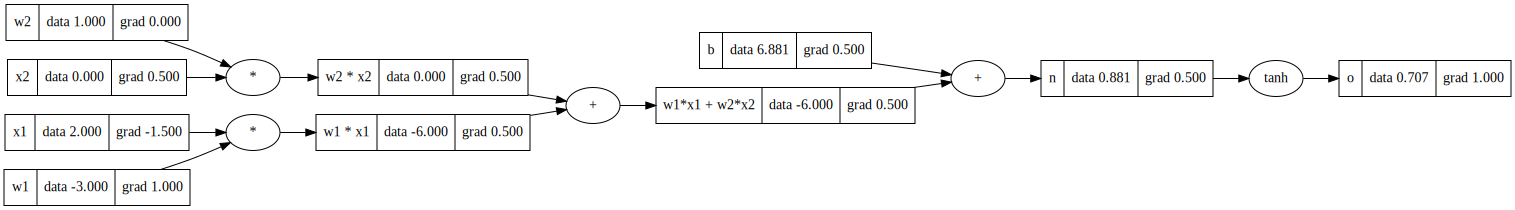

In [71]:
draw_dot(o)

# 5. backward function 구현

위 value 클래스에 backward 변수와 backward 함수를 구현한다.

add, mul, tanh 등 연산에 따라 값이 달라진다.

In [72]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weight x1, x2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813, label='b')

w1x1 = w1 * x1; w1x1.label = "w1 * x1"
w2x2 = w2 * x2; w2x2.label = "w2 * x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1*x1 + w2*x2"

n = w1x1w2x2 + b; n.label = "n"

# 위 value클래스에 tanh() 함수를 구현!
o = n.tanh(); o.label = 'o'

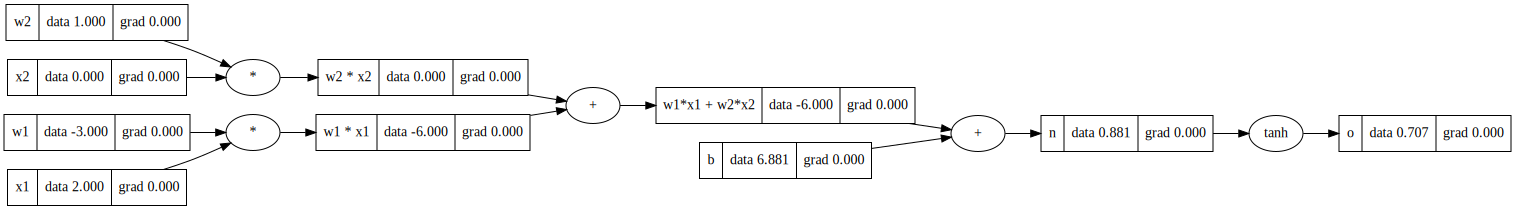

In [73]:
draw_dot(o)

In [74]:
### backward 함수 활용
## grad를 0으로 초기화 했기때문에 o.grad = 1로 먼저 설정해줘야 연산에서 0이 안된다.

o.grad = 1.0
o._backward() # n 노드의 grad를 계산함!

n._backward()

# b._backward() 뒤에 아무것도 없으니 안해도됨
w1x1w2x2._backward()

w1x1._backward()
w2x2._backward()

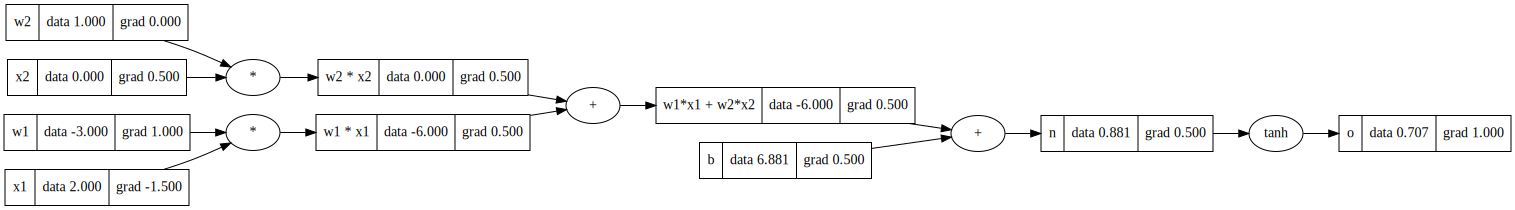

In [75]:
draw_dot(o)

**위에서 직접 구한 grad와 함수로 구현한 값이 잘 일치한다.!**

# 6. 위상정렬을 이용한 backpropagation

In [83]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weight x1, x2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813, label='b')

w1x1 = w1 * x1; w1x1.label = "w1 * x1"
w2x2 = w2 * x2; w2x2.label = "w2 * x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1*x1 + w2*x2"

n = w1x1w2x2 + b; n.label = "n"

# 위 value클래스에 tanh() 함수를 구현!
o = n.tanh(); o.label = 'o'

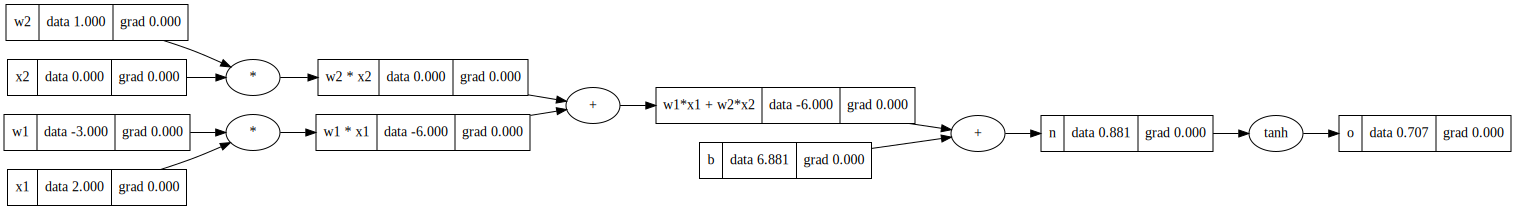

In [84]:
draw_dot(o)

In [85]:
## 위상정렬로 data 순서대로 담기

topological = []

visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topological.append(v)

build_topo(o)
topological        

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.8813),
 Value(data=0.8813000000000004),
 Value(data=0.7070699857622339)]

## 위상 정렬로 나온 순서대로 backward 진행하기

In [86]:
o.grad = 1.0

topological = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topological.append(v)

build_topo(o)


for node in reversed(topological):
    node._backward()

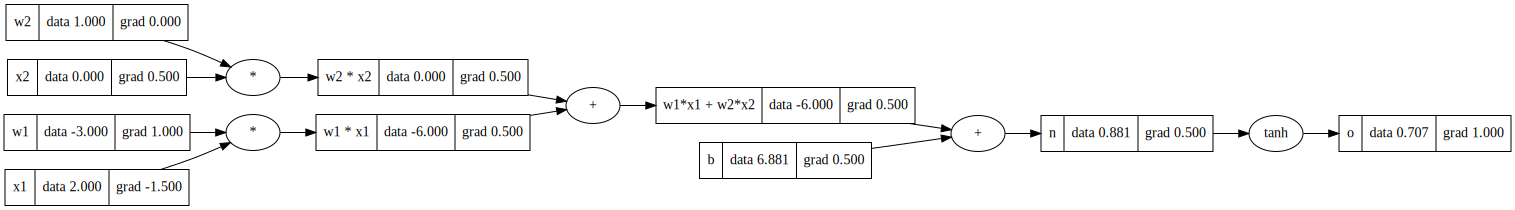

In [87]:
draw_dot(o)

잘 진행 된다! 이제 value 클래스에 구현해 놓자

In [89]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weight x1, x2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813, label='b')

w1x1 = w1 * x1; w1x1.label = "w1 * x1"
w2x2 = w2 * x2; w2x2.label = "w2 * x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = "w1*x1 + w2*x2"

n = w1x1w2x2 + b; n.label = "n"

# 위 value클래스에 tanh() 함수를 구현!
o = n.tanh(); o.label = 'o'

In [90]:
o.backward()

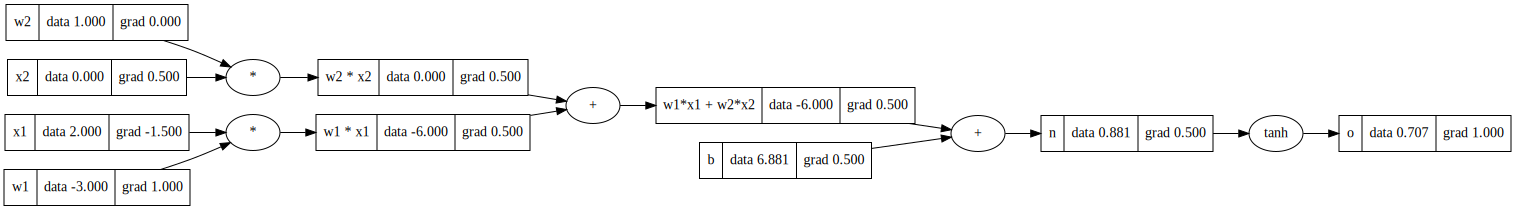

In [91]:
draw_dot(o)

**value클래스에 backward 함수로 구현한 것이 잘된다!**

# 버그 발견,, 수정

간단한 예시로 버그를 알아보자.

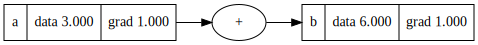

In [92]:
a = Value(3.0, label='a')

b = a + a; b.label = 'b'

b.backward()

draw_dot(b)

[문제]

1. 같은 변수를 사용하니 grad 계산이 틀림.

2. a의 grad는 2가 되어야 한다. a + a ==> 2*a
   
   a.grad = 1 * 2 = 2


또 다른 예시...

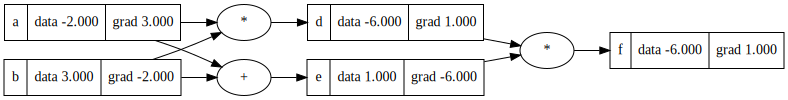

In [93]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

원인 = 같은 변수를 계산에 또 사용할때 grad 계산에서 이전 grad 값이 누적이 안되는 것이 문제였다.

self => a.grad = 1 // other => a.grad = 1 로 그냥 같은 것을 두 번 반복하는 것과 같다.

a.grad = a.grad + a.grad 가 되어야 한다.

[해결법]

self.grad `=` 이전 노드의(즉, 계산 후 노드) gard * 계산 식의 미분값

==> self.grad `+=` 이전 노드의(즉, 계산 후 노드) gard * 계산 식의 미분값


#### 다시 해보자

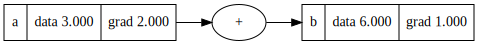

In [95]:
a = Value(3.0, label='a')

b = a + a; b.label = 'b'

b.backward()

draw_dot(b)

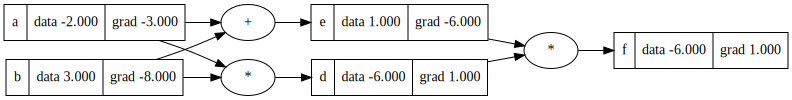

In [96]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')

d = a * b; d.label = 'd'
e = a + b; e.label = 'e'
f = d * e; f.label = 'f'

f.backward()

draw_dot(f)

#### 버그 해결!! 

# 다른 버그 ㅠ

1. a + 1 하면 1은 value클래스의 data가 아니기 때문에 에러가 발생한다.(mul도 마찬가지)

==> 만약 정수가 사용되면 value로 치환하는 작업을 추가한다.

2. 위에서 a * 2를 해결했지만 2 * a를 하면 또 인식을 못한다. ㅠ

==> 2 * a 와 같은 연산이 들어오면 a * 2로 바꿔주는 함수를 추가한다. (`__rmul__`) 추가